# Predicting Apartment Prices in Mexico City

In this project, I will predict the prices of apartments in Mexico City (Distrito Federal)

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

## Data Import, Cleaning and Preparation

There are 5 different csv files for this project. I will import one of them, clean it, add all the cleaning steps to a function, and apply the function to the rest of the csv files.

In [2]:
# Import csv file and inspect it
df1 = pd.read_csv('/workspaces/Predicting-Apartment-Prices-in-Mexico-City/mexico-city-real-estate-1.csv')
display(df1.head())
display(df1.info())

,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,1,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851900,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,2,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,3,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,4,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481480,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,5,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4628 entries, 0 to 4627
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  4628 non-null   int64  
 1   operation                   4628 non-null   object 
 2   property_type               4628 non-null   object 
 3   place_with_parent_names     4628 non-null   object 
 4   lat-lon                     4144 non-null   object 
 5   price                       4538 non-null   float64
 6   currency                    4538 non-null   object 
 7   price_aprox_local_currency  4538 non-null   float64
 8   price_aprox_usd             4538 non-null   float64
 9   surface_total_in_m2         1668 non-null   float64
 10  surface_covered_in_m2       4436 non-null   float64
 11  price_usd_per_m2            1150 non-null   float64
 12  price_per_m2                4249 non-null   float64
 13  floor                       291 n

None

Some of the columns contain null values. I will drop columns where at least 50% of its data are null values

In [3]:
# Checking columns with 50% of more missing values
(df1.isna().sum() / len(df1)) >= 0.5

Unnamed: 0                    False
operation                     False
property_type                 False
place_with_parent_names       False
lat-lon                       False
price                         False
currency                      False
price_aprox_local_currency    False
price_aprox_usd               False
surface_total_in_m2            True
surface_covered_in_m2         False
price_usd_per_m2               True
price_per_m2                  False
floor                          True
rooms                          True
expenses                       True
properati_url                 False
dtype: bool

The columns which have 50% of more missing data are: `surface_total_in_m2`, `price_usd_per_m2`, `floor`, `rooms`, `expenses`.
I will drop these columns

In [4]:
# Drop affected columns
df1.drop(columns=['surface_total_in_m2',
                  'price_usd_per_m2',
                  'floor',
                  'rooms',
                  'expenses'],
                  inplace=True)

Since I'm concerned with only the apartments in Mexico City - Distrito Federal, I will subset on the `property_type` and filter for apartments.

Also, I will subset on `place_with_parent_names` and filter for those that contain Distrito Federal

In [5]:
# Subset on properties that are apartments
apt_filter = df1['property_type'] == 'apartment'

# Subset on locations that contain Distrito Federal
state_filter = df1['place_with_parent_names'].str.contains('Distrito Federal')

# Apply the filters
df1 = df1[apt_filter & state_filter]

The next thing I will look at are categorical columns with low or high cardinality. Low cardinality columns are those with few unique values while the high cardinality ones with many unique values.

If there's only one category in a column, it won't provide any unique information to the model. Columns where nearly every row has its own category won't help the model in identifying useful trends in the data.

I will calculate the number of unique values for the categorical columns in the data.

In [6]:
# Number of unique values in each categorical columns
df1.select_dtypes('object').nunique()

operation                     1
property_type                 1
place_with_parent_names      15
lat-lon                    1433
currency                      2
properati_url              2760
dtype: int64

In [7]:
df1[['price_aprox_usd', 'surface_covered_in_m2']].describe()

,price_aprox_usd,surface_covered_in_m2
count,2.754000e+03,2624.000000
mean,2.154891e+05,128.730945
std,3.972478e+05,656.209935
min,7.823940e+03,0.000000
25%,5.133285e+04,60.000000
50%,9.620551e+04,80.000000
75%,2.046332e+05,110.000000
max,8.429837e+06,31840.000000


In [8]:
df1.head()

,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_covered_in_m2,price_per_m2,properati_url
0,1,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,54.0,101851.85190,http://miguel-hidalgo-df.properati.com.mx/o3zb...
2,3,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,100.0,9266.67000,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,4,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,135.0,47481.48148,http://miguel-hidalgo-df.properati.com.mx/opeq...
5,6,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"19.432657,-99.177444",4416000.0,MXN,4376051.62,232663.51,87.0,50758.62069,http://anzures.properati.com.mx/opct_venta_dep...
6,7,sell,apartment,|Benito Juárez|Distrito Federal|México|,"19.367025,-99.170349",3150000.0,MXN,3122244.47,166001.78,100.0,31500.00000,http://benito-juarez.properati.com.mx/r3a9_ven...


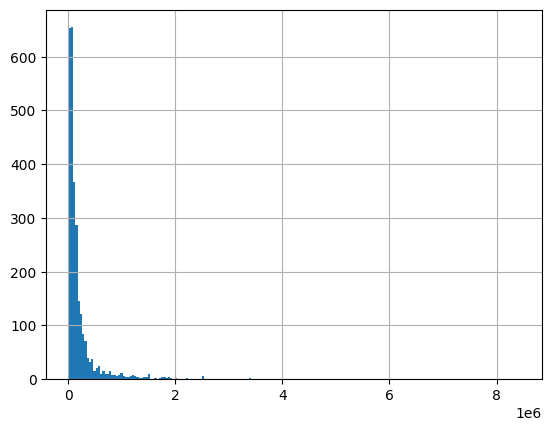

In [9]:
df1['price_aprox_usd'].hist(bins=200);

In [10]:
df1.isna().sum()

Unnamed: 0                      0
operation                       0
property_type                   0
place_with_parent_names         0
lat-lon                       279
price                           6
currency                        6
price_aprox_local_currency      6
price_aprox_usd                 6
surface_covered_in_m2         136
price_per_m2                  178
properati_url                   0
dtype: int64